In [1]:
from pathlib import Path
from sqlalchemy import text
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from shared.db import run_query

RESOLUTION: str = '1 week'
START_TIME: str = '2010-01-01 00:00'
END_TIME: str = '2022-12-31 23:59'
PROJECT_ID: str = 'c5d36b2e-cbb4-47a8-8370-e5f52bb78bf3'
ANNO_TECH: str = 'fc73da56-9f51-4d2b-ad35-2a01dbe9b275'
ANNO_SENT: str = 'e63da0c9-9bb5-4026-ab5e-7d5845cdc111'

TARGET_DIR = Path('figures')
TARGET_DIR = TARGET_DIR.resolve()
TARGET_DIR.mkdir(exist_ok=True, parents=True)

TECHNOLOGIES = {
    # 'Methane Removal': 0,
    # 'CCS': 1,
    'Ocean Fertilization': 2,
    'Ocean Alkalinization': 3,
    'Enhanced Weathering': 4,
    'Biochar': 5,
    'BECCS': 9,
    'Ecosystem Restoration': 7,
    'Soil Carbon Sequestration': 8,
    'Afforestation/Reforestation': 6,
    'Blue Carbon': 10,
    'Direct Air Capture': 11,
    'GGR (general)': 12
}

cum_tweets = {}
cum_users = {}
tpu = {}
buckets = []

for tech, ti in TECHNOLOGIES.items():
    stmt = text("""
    WITH buckets as (SELECT generate_series(:start_time ::timestamp,
                                            :end_time ::timestamp,
                                            :resolution) as bucket),
         labels as (SELECT DISTINCT ON (twitter_item.twitter_id, ba_tech.value_int) twitter_item.created_at,
                                                                                    twitter_item.twitter_author_id,
                                                                                    twitter_item.twitter_id,
                                                                                    ba_tech.value_int as technology
                    FROM twitter_item
                             LEFT OUTER JOIN bot_annotation ba_tech on (
                                twitter_item.item_id = ba_tech.item_id
                            AND ba_tech.bot_annotation_metadata_id = :ba_tech
                            AND ba_tech.key = 'tech')
                    WHERE twitter_item.project_id = :project_id
                      AND ba_tech.value_int = :technology)
    SELECT b.bucket                                                                                    as bucket,
           count(DISTINCT l.twitter_id)                                                                as cum_tweets,
           count(DISTINCT l.twitter_author_id)                                                         as cum_users,
           count(DISTINCT l.twitter_id)::float / nullif(count(DISTINCT l.twitter_author_id)::float, 0) as tpu
    FROM buckets b
             LEFT JOIN labels l ON (l.created_at < b.bucket)
    GROUP BY bucket
    ORDER BY bucket;
    """)

    result = run_query(stmt, {
        'start_time': START_TIME,
        'end_time': END_TIME,
        'resolution': RESOLUTION,
        'project_id': PROJECT_ID,
        'ba_tech': ANNO_TECH,
        'technology': ti
    })

    cum_tweets[tech] = np.array([r['cum_tweets'] for r in result], dtype=float)
    np.nan_to_num(cum_tweets[tech], nan=np.nanmedian(cum_tweets[tech]))
    cum_users[tech] = np.array([r['cum_users'] for r in result], dtype=float)
    cum_users[tech] = np.nan_to_num(cum_users[tech], nan=np.nanmedian(cum_users[tech]))
    tpu[tech] = np.array([r['tpu'] for r in result], dtype=float)
    tpu[tech] = np.nan_to_num(tpu[tech], nan=np.nanmedian(tpu[tech]))
    buckets = [r['bucket'] for r in result]

cum_tweets_np = np.array(list(cum_tweets.values()))
cum_users_np = np.array(list(cum_users.values()))
tpu_np = np.array(list(tpu.values()))


/tmp/ipykernel_11654/1447162193.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


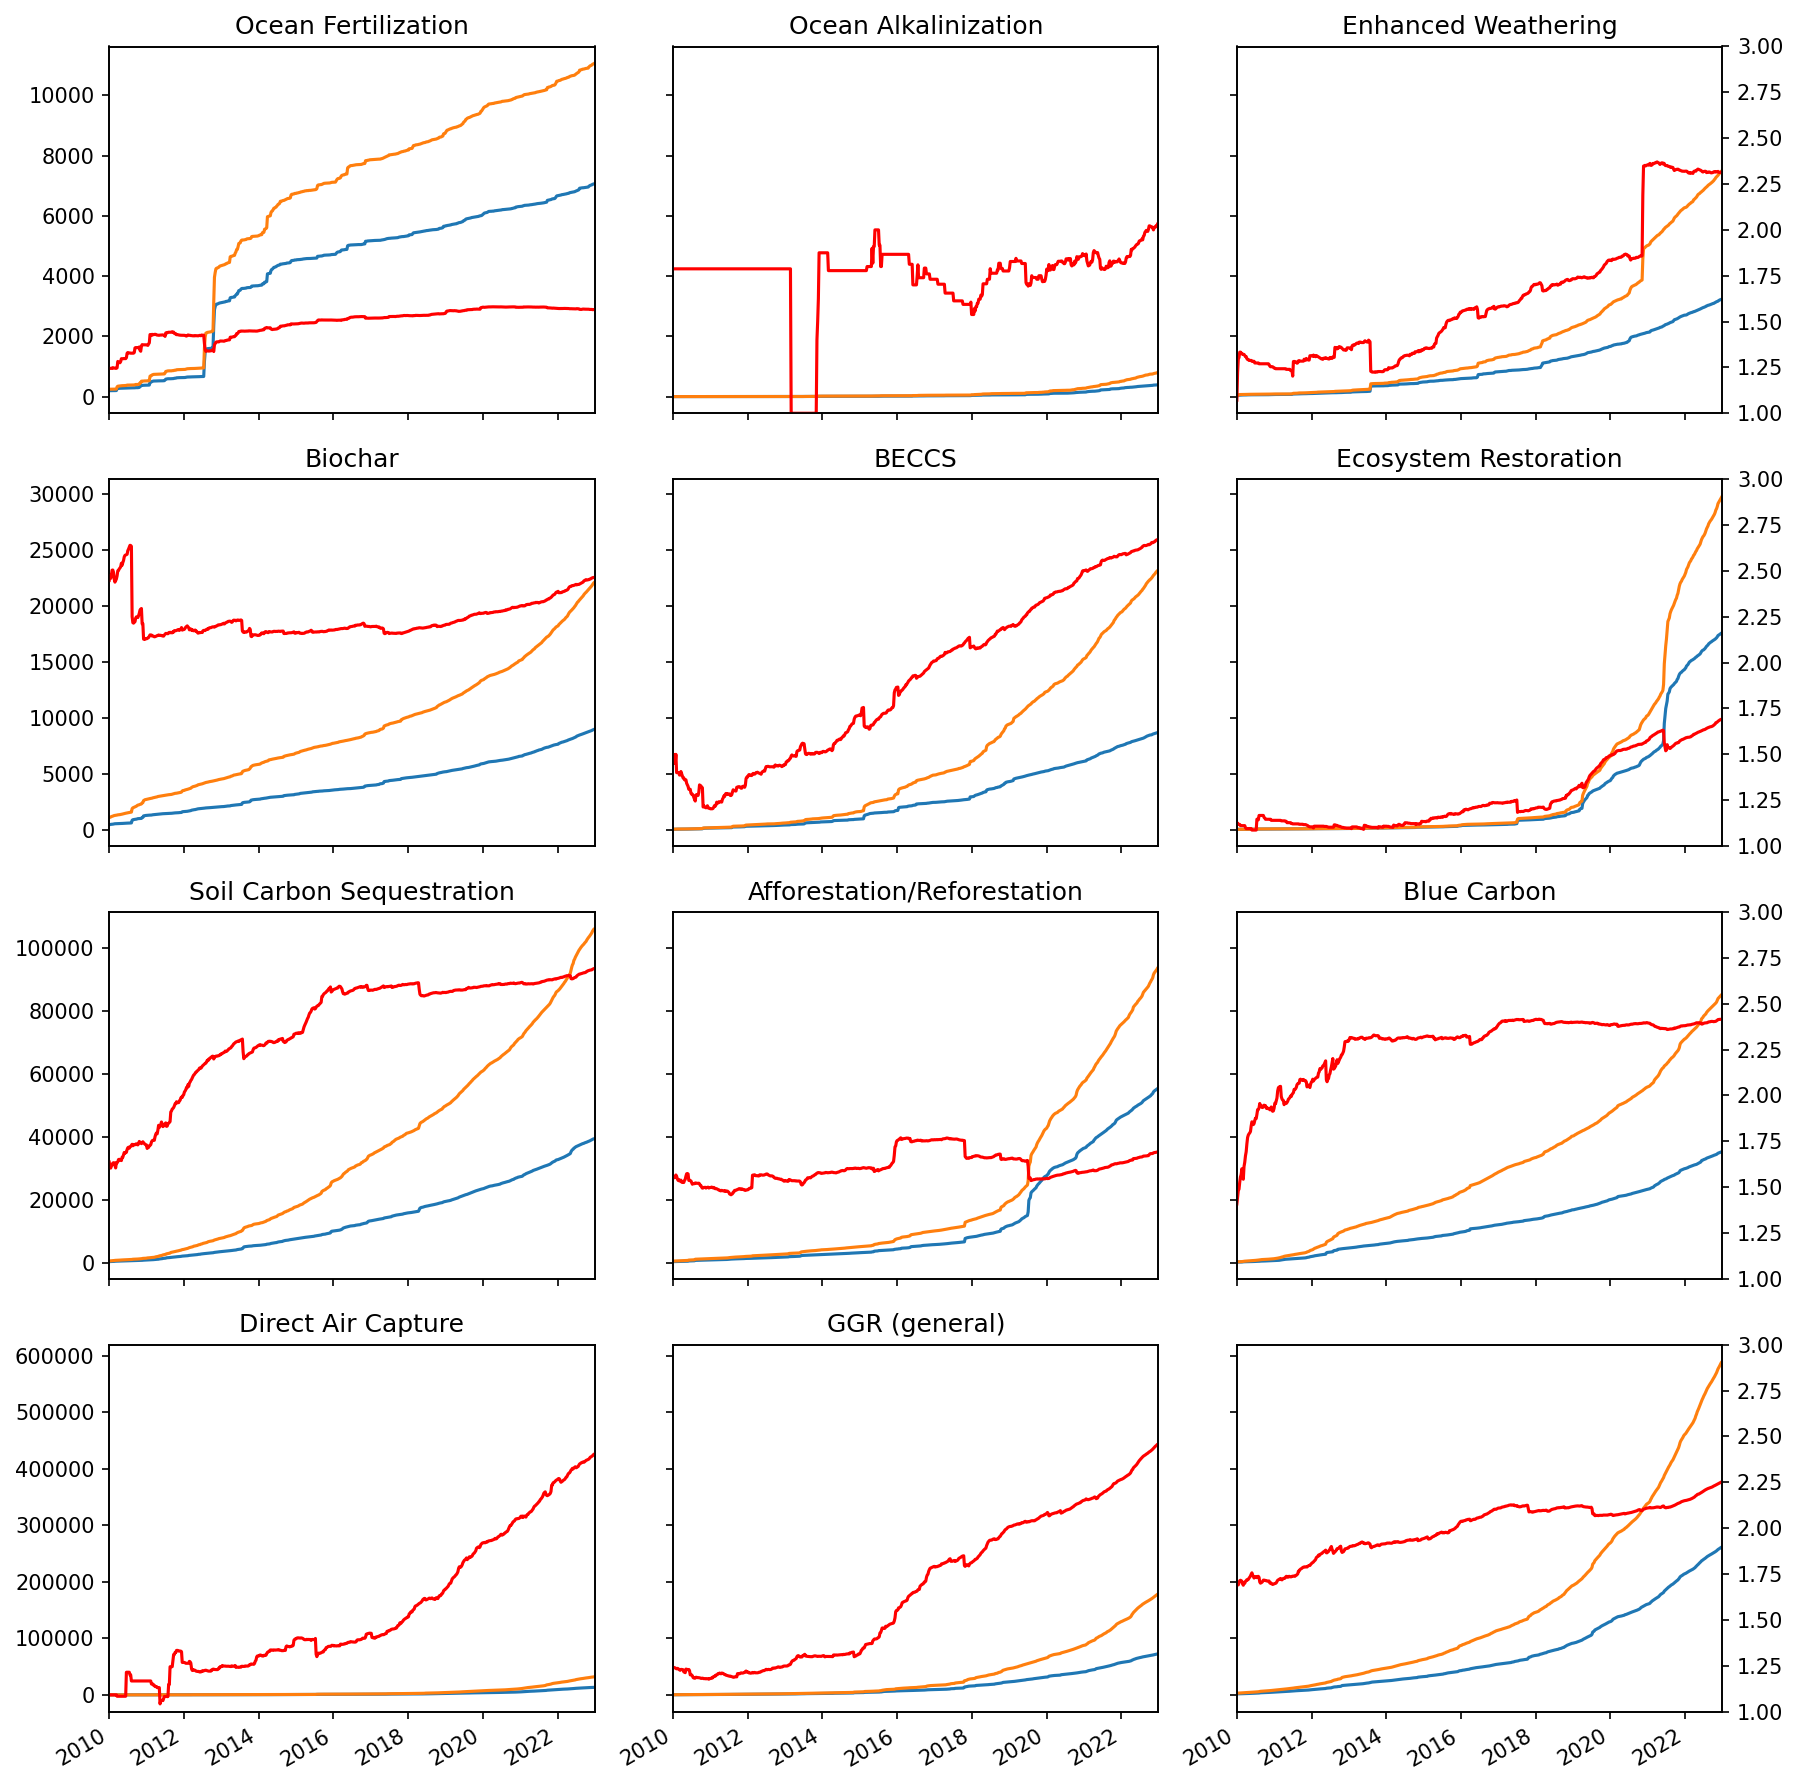

In [20]:
N_COLS = 3
N_ROWS = 4
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS), dpi=150, sharey='row')


def plot_cell(ax, n_users, n_tweets, tpu, ylim=None, xlim=None, subax_tl=False):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.plot(buckets, n_users, label='Number of users')
    ax.plot(buckets, n_tweets, label='Number of tweets')
    ax.set_xlim(buckets[0], buckets[-1])
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    subax = ax.twinx()
    subax.plot(buckets, tpu, label='Tweets per user', color='r')
    # subax.set_ylim(1, np.max(tpu))
    subax.set_ylim(1, 3)
    if not subax_tl:
        subax.tick_params(labelright=False, right=False)


for i, tech in enumerate(TECHNOLOGIES.keys()):
    row = i // N_COLS
    col = i % N_COLS
    axes[row][col].set_title(tech)
    plot_cell(axes[row][col],
              cum_users[tech],
              cum_tweets[tech],
              tpu[tech],
              subax_tl=col==(N_COLS-1))
              # ylim=(0, 100000))

plot_cell(axes[3][2],
          cum_users_np.sum(axis=0),
          cum_tweets_np.sum(axis=0),
          cum_tweets_np.sum(axis=0) / cum_users_np.sum(axis=0),
          subax_tl=True)
# ax.set_title(technology)

fig.autofmt_xdate()
fig.tight_layout()
fig.show()
